In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
%matplotlib inline

## Prob 1

In [2]:
sort = None
def resort():
    data = pd.read_csv("titanic4real.csv")
    return np.random.permutation(np.arange(len(data)))
sort = resort()
def initialize(pclass_change=True):
    allData = pd.read_csv("titanic4real.csv")
    
    labels = allData["Survived"]
    data  = allData[["Pclass","Sex","Age","Fare","Sibsp","Parch","Embarked"]]
    data = data.replace({'male': 1, 'female': 0,"S":1,"C":2,"Q":3})
    data = data.fillna(0)
    labels = labels.fillna(0)
    
    if pclass_change:
        data["FirstClass"] = (data["Pclass"] == 1)*1
        data["SecondClass"] = (data["Pclass"] == 2)*1
        data = data.drop("Pclass",axis=1)
    
   
    num_train = int(len(data)*.6)
    train = data.ix[sort][:num_train]
    test = data.ix[sort][num_train:]
    
    trainLabels = labels[sort][:num_train]
    testLabels = labels[sort][num_train:]
    return train,trainLabels,test,testLabels

## Prob 2

In [3]:
def best_tau(predicted_labels, true_labels, n_tau=100, plot=True):
    """
    Parameters
    ----------
    predicted_labels : ndarray of shape (n,)
    The predicted labels for the data
    true_labels : ndarray of shape (n,)
    The actual labels for the data
    n_tau : int
    The number of values to try for tau
    plot : boolean
    Whether or not to plot the roc curve
    Returns
    -------
    best_tau : float
    The optimal value for tau for the data.
    """
    best_tau = None
    best = -np.infty
    Tau = np.linspace(0,1,n_tau)
    
    FPRs = np.empty(n_tau)
    TPRs = np.empty(n_tau)
    
    for i,tau in enumerate(Tau):
        TP = np.sum((labels >= tau) & (true_Labels == 1))
        TN = np.sum((labels < tau) & (true_Labels == 0))

        FP = np.sum((labels >= tau) & (true_Labels == 0))
        FN = np.sum((labels < tau) & (true_Labels == 1))
        
        TPR = TP/(TP+FN)
        FPR = FP/(FP+TN)
        
        FPRs[i] = FPR
        TPRs[i] = TPR
        
        val = TPR - FPR
        if val > best:
            best = val
            best_tau = tau
    if(plot):
        plt.plot(FPRs,TPRs)

## Prob 3

In [4]:
def auc_scoreLogReg(C,pclass_change=True,plot = True):
    
    train,trainLabels,test,testLabels = initialize(pclass_change)
    
    model = LogisticRegression(C=C)
    
    model.fit(train,trainLabels)
    
    predict = model.predict_proba(test)
    
    FPR, TPR, threshold = sklearn.metrics.roc_curve(
        testLabels, predict[:,1], pos_label=1)
    
    if plot:
        plt.plot(FPR,TPR)
        if pclass_change:
            plt.title("LogReg Changed, C={}".format(C))
        else:
            plt.title("LogReg Unchanged, C={}".format(C))
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()
    return sklearn.metrics.auc(FPR,TPR)

In [5]:
def auc_scoresLogReg(unchanged_logreg, changed_logreg):
    """
    Parameters
    ----------
    unchanged_logreg : float in (0,1)
    The value to use for C in the unchanged model
    changed_logreg : float in (0,1)
    The value to use for C in the changed model
    Returns
    -------
    unchanged_auc : float
    The auc for the unchanged model
    changed_auc : float
    The auc for the changed model
    """
    
    return auc_scoreLogReg(unchanged_logreg,pclass_change=False,plot=False),\
           auc_scoreLogReg(changed_logreg,pclass_change=True,plot=False)
auc_scoresLogReg(.5,.5)

(0.82035690882213985, 0.82466968408540198)

## Prob 4

In [6]:
def auc_scoreBayes(alpha,pclass_change=True,plot = True):
    
    train,trainLabels,test,testLabels = initialize(pclass_change)
    
    model = MultinomialNB(alpha=alpha)
    
    model.fit(train,trainLabels)
    
    predict = model.predict_proba(test)
    
    FPR, TPR, threshold = sklearn.metrics.roc_curve(
        testLabels, predict[:,1], pos_label=1)
    
    if plot:
        plt.plot(FPR,TPR)
        if pclass_change:
            plt.title("Bayes Changed, alpha={}".format(alpha))
        else:
            plt.title("Bayes Unchanged, alpha={}".format(alpha))
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()
    return sklearn.metrics.auc(FPR,TPR)
def auc_scoresBayes(unchanged_bayes, changed_bayes):
    """
    Parameters
    ----------
    unchanged_logreg : float in (0,1)
    The value to use for C in the unchanged model
    changed_logreg : float in (0,1)
    The value to use for C in the changed model
    Returns
    -------
    unchanged_auc : float
    The auc for the unchanged model
    changed_auc : float
    The auc for the changed model
    """
    
    return auc_scoreBayes(unchanged_bayes,pclass_change=False,plot=False),\
           auc_scoreBayes(changed_bayes,pclass_change=True,plot=False)
auc_scoresBayes(.5,.5)

(0.70212133680793665, 0.69392249196116973)

In [7]:
def auc_scores(unchanged_logreg, changed_logreg,
               unchanged_bayes, changed_bayes):
    """
    Parameters
    ----------
    unchanged_logreg : float in (0,1)
    The value to use for C in the unchanged model
    changed_logreg : float in (0,1)
    The value to use for C in the changed model
    Returns
    -------
    unchanged_auc : float
    The auc for the unchanged model
    changed_auc : float
    The auc for the changed model
    """
    
    return (auc_scoresLogReg(unchanged_logreg,changed_logreg)+ 
            auc_scoresBayes(unchanged_bayes,changed_bayes))
auc_scores(.5,.5,.5,.5)

(0.82035690882213985,
 0.82466968408540198,
 0.70212133680793665,
 0.69392249196116973)

## Prob 5

In [8]:
def find_best_parameters(num):
    """
    Parameters
    ----------
    num : int
    The number of values to try for C and alpha
    Returns
    -------
    best : list of length 4
    The best values for C for the unchanged and changed logistic
    regression models, and the best values for alpha for the
    unchanged and changed Naive Bayes models, respectively.
    """
    best_params = [None]*4
    bests = [-np.infty]*4
    
    for param in np.linspace(0,1,num)[1:-1]:
        vals = auc_scores(*([param]*4))
        
        for i in range(4):
            if vals[i] > bests[i]:
                best_params[i] = param
                bests[i] = vals[i]
    return best_params

## Prob 6

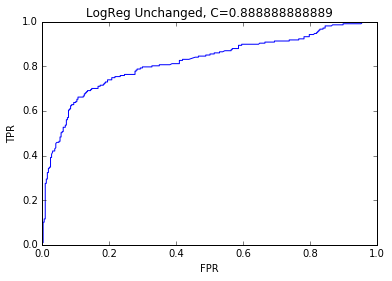

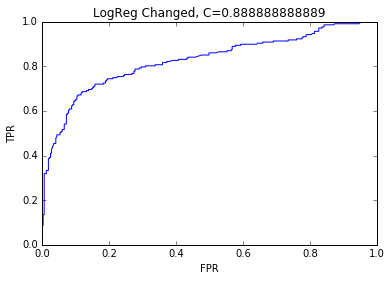

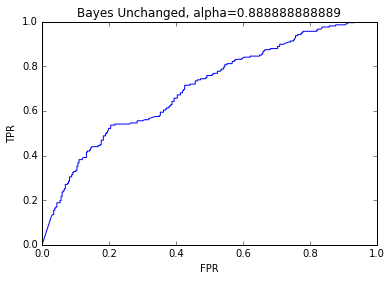

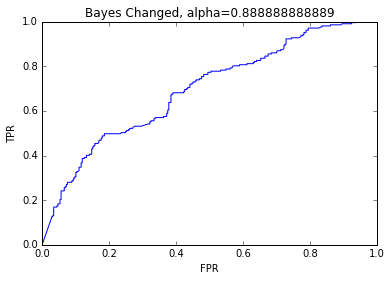

Bayes Changed   0.693876773495
Bayes Unchanged   0.702067998598
LogReg Unchanged   0.81996068212
LogReg Changed   0.825751687773


In [9]:
def results():
    params = find_best_parameters(10)
    scores = np.empty(4)
    scores[0] = auc_scoreLogReg(params[0],pclass_change=False,plot = True)
    scores[1] = auc_scoreLogReg(params[1],pclass_change=True,plot = True)
    scores[2] = auc_scoreBayes(params[0],pclass_change=False,plot = True)
    scores[3] = auc_scoreBayes(params[1],pclass_change=True,plot = True)
    names = ("LogReg Unchanged","LogReg Changed",
             "Bayes Unchanged","Bayes Changed")
    for name,score in np.array(zip(names,scores))[np.argsort(scores)]:
        print name," ",score
results()

LogReg Changed did the best